In [1]:
import xarray as xr
import os
import pandas as pd
import tqdm
import numpy as np
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import cmocean

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [52]:
# parameters cell
input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/oifs/00001']

input_names = ['PICT']
accumulation_period = 21600 # output frequency of OpenIFS in seconds
mass_to_heat = 'true'
exps = range(1, 2)
figsize=(8, 4)
dpi = 300
ofile = None

var = ['SF','PRECIP','CI','T2M','SKT']
mapticks = [-5,-3,-2,-1,-0.5,-0.25,0,0.25,0.5,1,2,3,5]
contour_outline_thickness = 0.1

In [3]:
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [54]:
# Load model data

if mass_to_heat == 'true':
    m2h_factor = 333500000
else:
    m2h_factor = 1

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in var:
        paths = []
        data[exp_name][v] = []
        for exp in tqdm.tqdm(exps):
            if v == 'SF' or v == 'PRECIP':
                path = exp_path+'/'+v+'_'+f'{exp:05d}.nc'
                data[exp_name][v].append(cdo.yearmean(input="-remapcon,r360x180 "+str(path),returnArray=v)/accumulation_period)
            else:
                path = exp_path+'/'+v+'_'+f'{exp:05d}.nc'
                data[exp_name][v].append(cdo.yearmean(input="-remapcon,r360x180 "+str(path),returnArray=v))
                

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


In [56]:
crf_sw_model = OrderedDict()
crf_sw_model_mean = OrderedDict()


for exp_name in input_names:
    crf_sw_model[exp_name] = {}
    crf_sw_model_mean[exp_name]= {}
    for v in var:
        crf_sw_model[exp_name][v] = np.squeeze(data[exp_name][v])
        crf_sw_model_mean[exp_name][v] = np.mean(crf_sw_model[exp_name][v],axis=0)
        
        lon = np.arange(0, 360, 1)
        lat = np.arange(-90, 90, 1)
        crf_sw_model_mean[exp_name][v], lon = add_cyclic_point(crf_sw_model_mean[exp_name][v], coord=lon)

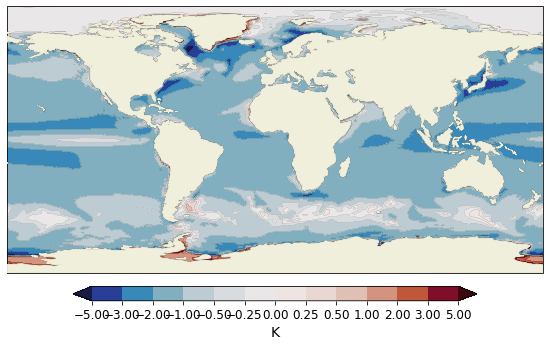

In [57]:
nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)
    axes[i].add_feature(cfeature.LAND,zorder=4)

    
    
    imf=plt.contourf(lon, lat, crf_sw_model_mean[exp_name]['T2M']-crf_sw_model_mean[exp_name]['SKT'], cmap=cmocean.cm.balance, 
                     levels=mapticks, extend='both',
                     transform=ccrs.PlateCarree(),zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(lon, lat, crf_sw_model_mean[exp_name]['T2M']-crf_sw_model_mean[exp_name]['SKT'], colors=line_colors, 
                    levels=mapticks, linewidths=contour_outline_thickness,
                    transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('W/m²')
    axes[i].set_xlabel('Simulation Year')
    
    plt.tight_layout() 

    i = i+1
    
    cbar_ax_abs = fig.add_axes([0.15, -0.06, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=mapticks)
    cb.set_label(label="K", size='14')
    cb.ax.tick_params(labelsize='12')

ofile='t2m-skt_difference'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi, bbox_inches='tight')
    #os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    #os.system(f'mv {ofile}_trimmed.png {ofile}')

In [61]:
#Physics
t2m = crf_sw_model_mean[exp_name]['T2M']
skt = crf_sw_model_mean[exp_name]['SKT']
prec = crf_sw_model_mean[exp_name]['PRECIP']
snow = crf_sw_model_mean[exp_name]['SF']
sic = crf_sw_model_mean[exp_name]['CI']

heat = ((t2m-skt)*prec*1000000*4.2) - ((t2m-skt)*snow*1000000*2.2)

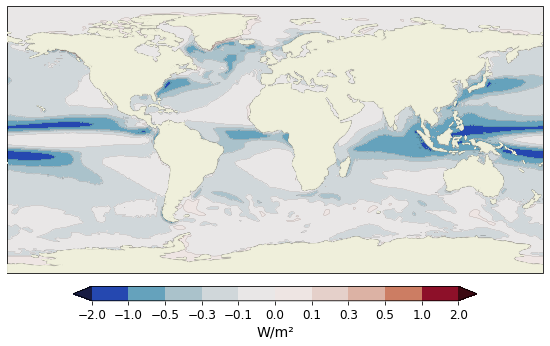

In [62]:
mapticks = [-2,-1,-0.5,-0.3,-0.1,0,0.1,0.3,0.5,1,2]

nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)
    axes[i].add_feature(cfeature.LAND,zorder=4)

    
    
    imf=plt.contourf(lon, lat, heat, cmap=cmocean.cm.balance, 
                     levels=mapticks, extend='both',
                     transform=ccrs.PlateCarree(),zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(lon, lat, heat, colors=line_colors, 
                    levels=mapticks, linewidths=contour_outline_thickness,
                    transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('W/m²')
    axes[i].set_xlabel('Simulation Year')
    
    plt.tight_layout() 

    i = i+1
    
    cbar_ax_abs = fig.add_axes([0.15, -0.06, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=mapticks)
    cb.set_label(label="W/m²", size='14')
    cb.ax.tick_params(labelsize='12')

ofile='heatflux_precip_t2m_skt'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi, bbox_inches='tight')
    #os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    #os.system(f'mv {ofile}_trimmed.png {ofile}')